# Classification II –   Homework

**Overview**
- [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)
- Target –   pos/neg folders

**Evaluation Criteria** (max score - 8):
* Text preprocessing - 3
    – Removing stop words
    - Stemming / Lemmatization
    - Bag of words / TF-IDF
    - N-grams
* Words importance - 2
* Hyperparameters tuning – 1
* Compare performance of models: SGDClassifier; SVM; Naive Bayes - 2
* Metric: AUC-ROC
* Libraries: scikit‑learn  + NLTK

TODO:
- is TF-IDF a good thing here (place high value to movie-specific words)
- how to output probabilities for SVM or NB? (do we need to care about NB calibrating for NB?)

Room for improvement:
- account for negation (not, don't, etc) instead on relying solely on something like 'absolutely amazing' or 'completely sucks'
- advanced stemming/lemmatization (e.g. define noun/verb/adj based on context - spacy)
- resplit into train/test sets

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import Normalizer

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

dfdfd

In [2]:
DATASET_DIR = 'D:/datasets/aclImdb'

def load_data(dir_name):
    X, y = [], []
    for sub_dir, target in (('pos', 1), ('neg', 0)):
        files = os.listdir(os.path.join(dir_name, sub_dir))
        X += [open(os.path.join(dir_name, sub_dir, fname),
                   encoding="utf-8"
                  ).read() for fname in files]
        y += [target] * len(files)
    return X, y

txt_train, y_train = load_data(os.path.join(DATASET_DIR, 'train'))
txt_test, y_test = load_data(os.path.join(DATASET_DIR, 'test'))

print('Train set size: ', len(txt_train))
print('Test set size: ', len(txt_test))

Train set size:  25000
Test set size:  25000


dfdfdf

In [3]:
stop_words = stopwords.words('english') + ['movie', 'film']
tokenizer = RegexpTokenizer(r"(?u)\b[^\W\d][^\W\d]+\b")
stemmer = EnglishStemmer()
lemmer = WordNetLemmatizer()

def preprocessor(text):
    return BeautifulSoup(text).get_text().lower()

def stemmed_words(doc):
    return [
        stemmer.stem(word)
        for word in tokenizer.tokenize(doc)
        if word not in stop_words
    ]

def lemmed_words(doc):
    return [
        lemmer.lemmatize(word)
        for word in tokenizer.tokenize(doc)
        if word not in stop_words
    ]

In [4]:
def show_scores(model, X_train, X_test, y_train, y_test):
    y_train_scores = model.predict_proba(X_train)[:,1]
    y_test_scores = model.predict_proba(X_test)[:,1]
    y_train_pred = y_train_scores >= 0.5
    y_test_pred = y_test_scores >= 0.5
    print("Train set: ROCAUC = {0:.6f}, accuracy = {1:.6f}".format(
        roc_auc_score(y_train, y_train_scores), accuracy_score(y_train, y_train_pred)
    ))
    print("Test set: ROCAUC = {0:.6f}, accuracy = {1:.6f}".format(
        roc_auc_score(y_test, y_test_scores), accuracy_score(y_test, y_test_pred)
    ))

In [5]:
def print_feature_summary(vectorizer, txt_array):
    feature_names = np.array(vectorizer.get_feature_names())
    X = vectorizer.transform(txt_array)
    sums = np.array(X.sum(axis=0))[0]
    sorted_idx = sums.argsort()

    print('Total features:', len(feature_names))
    print("First 20 features:\n{}".format(feature_names[:20]))
    print("Features with highest count: \n{}".format(
        feature_names[sorted_idx[-20:]]))
    print("Features with lowest count:\n{}".format(
        feature_names[sorted_idx[:20]]))

dfdf

In [6]:
models = {}

### Baseline model

In [7]:
pipe = Pipeline(steps=[
    ('bag', CountVectorizer(preprocessor=preprocessor)),
    ('nb', MultinomialNB())
])
pipe.fit(txt_train, y_train)
show_scores(pipe, txt_train, txt_test, y_train, y_test)
models['Naive Bayes (baseline)'] = pipe

Train set: ROCAUC = 0.962615, accuracy = 0.898040
Test set: ROCAUC = 0.891960, accuracy = 0.814320


In [8]:
print_feature_summary(pipe.named_steps['bag'], txt_train)

Total features: 75903
First 20 features:
['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02']
Features with highest count: 
['he' 'not' 'on' 'you' 'film' 'but' 'movie' 'with' 'for' 'as' 'was' 'that'
 'this' 'in' 'it' 'is' 'to' 'of' 'and' 'the']
Features with lowest count:
['labours' 'lilienthal' 'lilililililii' 'lilleheie' 'lillete' 'lilley'
 'lillihamer' 'liman' 'likings' 'limbless' 'limitlessly' 'limned' 'limos'
 'limpest' 'limpid' 'linage' 'linch' 'limburger' 'linchpin' 'likeminded']


### Vectorization tuning

setting min_df manually

In [20]:
pipe = Pipeline(steps=[
    ('bag', CountVectorizer(preprocessor=preprocessor, min_df=50)),
    ('nb', MultinomialNB())
])
params = {
    'bag__tokenizer': [stemmed_words, lemmed_words],
    'bag__ngram_range': [(1, 1), (1, 2)],
}
grid = GridSearchCV(pipe, params, cv=2, scoring='roc_auc', n_jobs=7)
grid.fit(txt_train, y_train)

show_scores(grid, txt_train, txt_test, y_train, y_test)
print("Best parameters:", grid.best_params_)

Train set: ROCAUC = 0.935962, accuracy = 0.872240
Test set: ROCAUC = 0.918698, accuracy = 0.852040
Best parameters: {'bag__ngram_range': (1, 2), 'bag__tokenizer': <function lemmed_words at 0x000001F36936C620>}


In [21]:
print_feature_summary(grid.best_estimator_.named_steps['bag'], txt_train)

Total features: 7594
First 20 features:
['abandon' 'abandoned' 'abc' 'ability' 'able' 'able get' 'able see'
 'abound' 'abraham' 'abrupt' 'abruptly' 'absence' 'absent' 'absolute'
 'absolutely' 'absolutely loved' 'absolutely nothing' 'absorbed'
 'absorbing' 'absurd']
Features with highest count: 
['first' 'great' 'also' 'bad' 'people' 'much' 'scene' 'well' 'really'
 'see' 'make' 'would' 'get' 'even' 'story' 'character' 'good' 'time'
 'like' 'one']
Features with lowest count:
['realistically' 'another woman' 'much love' 'intensely' 'man woman'
 'think really' 'thought great' 'almost everything' 'character play'
 'rambling' 'find hard' 'way end' 'one woman' 'order get' 'last one'
 'possibly worst' 'u believe' 'plodding' 'kept thinking' 'people one']


In [11]:
vectorizer_kwargs = {
    'preprocessor': preprocessor,
    'tokenizer': lemmed_words,
    'min_df': 50,
    'ngram_range': (1, 2),
}

### Naive Bayes

We're not using TF-IDF (distribution is not gaussian)

No scaling needed.
Calibrating? Why no smoothing works best?

In [12]:
pipe = Pipeline(steps=[
    ('bag', CountVectorizer(**vectorizer_kwargs)),
    ('nb', MultinomialNB()),
])
params = {
    'nb__alpha': [0, 1],
}
grid = GridSearchCV(pipe, params, cv=4, scoring='roc_auc', n_jobs=7)
grid.fit(txt_train, y_train)
models['Naive Bayes'] = grid.best_estimator_

show_scores(grid, txt_train, txt_test, y_train, y_test)
print("Best parameters:", grid.best_params_)

Train set: ROCAUC = 0.935962, accuracy = 0.872240
Test set: ROCAUC = 0.918698, accuracy = 0.852040
Best parameters: {'nb__alpha': 1}


In [13]:
def show_bayes_word_importance(model):
    feature_names = model.named_steps['bag'].get_feature_names()
    pos_feats = zip(model.named_steps['nb'].feature_log_prob_[0], feature_names)
    neg_feats = zip(model.named_steps['nb'].feature_log_prob_[1], feature_names)
    pos_feats_sorted = [x[1] for x in sorted(pos_feats, key=lambda x: x[0])]
    neg_feats_sorted = [x[1] for x in sorted(neg_feats, key=lambda x: x[0])]
    print('Top positive features:\n', pos_feats_sorted[:20], '\n')
    print('Top negative features:\n', neg_feats_sorted[:20])
    
show_bayes_word_importance(models['Naive Bayes'])

Top positive features:
 ['excellently', 'still great', 'delightfully', 'favorite movie', 'perfectly cast', 'walter matthau', 'absolutely loved', 'acting superb', 'best role', 'excellent job', 'wonderful performance', 'deliciously', 'ensemble cast', 'expertly', 'favorite character', 'heart warming', 'thoroughly enjoyed', 'another great', 'english subtitle', 'enjoyed much'] 

Top negative features:
 ['acting horrible', 'avoid like', 'acting awful', 'badly written', 'boll', 'even worth', 'possibly worst', 'skip one', 'total waste', 'uwe', 'uwe boll', 'worst acting', 'worst film', 'avoid cost', 'poorly made', 'seen bad', 'acting poor', 'complete waste', 'dreck', 'far worst']


Hilarious!

### SGD (logistic regression, L2-regularization)

WTF: no probabilities available for hinge loss

In [14]:
pipe = Pipeline(steps=[
    ('bag', CountVectorizer(**vectorizer_kwargs)),
    ('lin', SGDClassifier(loss='log', penalty='l2')),
])
params = {
    'lin__alpha': [1e-4, 1e-3, 1e-2],
}
grid = GridSearchCV(pipe, params, cv=4, scoring='roc_auc', n_jobs=7)
grid.fit(txt_train, y_train)
models['SGD Logistic regression'] = grid.best_estimator_

show_scores(grid, txt_train, txt_test, y_train, y_test)
print("Best parameters:", grid.best_params_)

Train set: ROCAUC = 0.957025, accuracy = 0.894040
Test set: ROCAUC = 0.942232, accuracy = 0.872960
Best parameters: {'lin__alpha': 0.01}


In [15]:
def show_linear_word_importance(model):
    feature_names = model.named_steps['bag'].get_feature_names()
    feats = list(zip(model.named_steps['lin'].coef_[0], feature_names))
    pos_feats = [x for x in feats if x[0] > 0]
    neg_feats = [x for x in feats if x[0] < 0]
    pos_feats_sorted = [x[1] for x in sorted(pos_feats, key=lambda x: x[0], reverse=True)]
    neg_feats_sorted = [x[1] for x in sorted(neg_feats, key=lambda x: x[0])]
    print('Top positive features:\n', pos_feats_sorted[:20], '\n')
    print('Top negative features:\n', neg_feats_sorted[:20])
    
show_linear_word_importance(models['SGD Logistic regression'])

Top positive features:
 ['excellent', 'great', 'perfect', 'wonderful', 'favorite', 'amazing', 'loved', 'fun', 'best', 'today', 'brilliant', 'one best', 'enjoyed', 'highly', 'beautiful', 'superb', 'definitely', 'enjoy', 'fantastic', 'love'] 

Top negative features:
 ['worst', 'awful', 'waste', 'bad', 'boring', 'poor', 'terrible', 'worse', 'nothing', 'horrible', 'dull', 'unfortunately', 'stupid', 'poorly', 'annoying', 'save', 'supposed', 'waste time', 'instead', 'script']


### SGD (TF-IDF, logistic regression, L2-regularization)

In [16]:
pipe = Pipeline(steps=[
    ('bag', CountVectorizer(**vectorizer_kwargs)),
    ('tfidf', TfidfTransformer()),
    ('lin', SGDClassifier(loss='log', penalty='l2')),
])
params = {
    'lin__alpha': [1e-4, 1e-3, 1e-2],
}
grid = GridSearchCV(pipe, params, cv=4, scoring='roc_auc', n_jobs=7)
grid.fit(txt_train, y_train)
models['SGD Logistic regression with TF-IDF'] = grid.best_estimator_

show_scores(grid, txt_train, txt_test, y_train, y_test)
print("Best parameters:", grid.best_params_)

Train set: ROCAUC = 0.967434, accuracy = 0.905200
Test set: ROCAUC = 0.951800, accuracy = 0.880760
Best parameters: {'lin__alpha': 0.0001}


In [17]:
show_linear_word_importance(models['SGD Logistic regression with TF-IDF'])

Top positive features:
 ['great', 'excellent', 'best', 'wonderful', 'perfect', 'amazing', 'favorite', 'well', 'love', 'loved', 'fun', 'brilliant', 'today', 'enjoyed', 'one best', 'also', 'superb', 'beautiful', 'life', 'highly'] 

Top negative features:
 ['worst', 'bad', 'awful', 'waste', 'boring', 'poor', 'nothing', 'terrible', 'worse', 'horrible', 'dull', 'unfortunately', 'even', 'stupid', 'poorly', 'script', 'supposed', 'minute', 'annoying', 'ridiculous']


### Linear SVM (with TF-IDF)
A lot of features, let's stick to linear kernel.
No poly - we are already using bigrams.
Does not interact properly with pipeline

In [18]:
vect = Pipeline(steps=[
    ('bag', CountVectorizer(**vectorizer_kwargs)),
    ('tfidf', TfidfTransformer(norm='l2')),
])

vect.fit(txt_train)
X_train = vect.transform(txt_train)
X_test = vect.transform(txt_test)

params = {
    'C': [0.01, 0.1, 1],
}
grid = GridSearchCV(LinearSVC(), params, cv=2, scoring='roc_auc', n_jobs=7)
grid.fit(X_train, y_train)
clf = CalibratedClassifierCV(grid.best_estimator_, cv='prefit', method='sigmoid')
clf.fit(X_train, y_train)

show_scores(clf, X_train, X_test, y_train, y_test)
print("Best parameters:", grid.best_params_)

models['Linear SVM with TF-IDF'] = clf

Train set: ROCAUC = 0.977135, accuracy = 0.923480
Test set: ROCAUC = 0.954535, accuracy = 0.884920
Best parameters: {'C': 0.1}


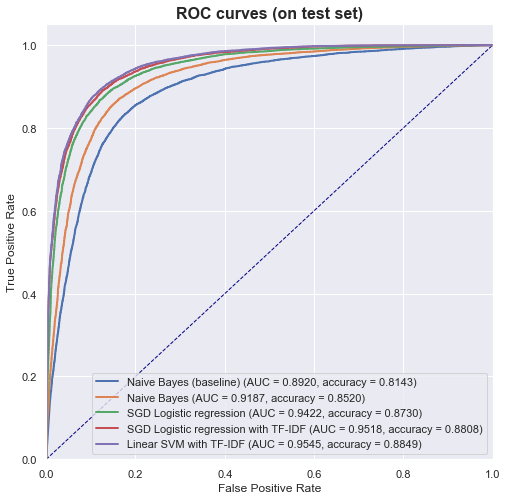

In [19]:
def plot_roc_curves(models):
    """ Show ROC curves for all models on a single plot."""
    plt.figure(figsize = (8, 8))
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    
    for name, model in models.items():
        
        if type(model) is CalibratedClassifierCV:
            y_test_scores = model.predict_proba(X_test)[:,1]
        else:
            y_test_scores = model.predict_proba(txt_test)[:,1]
            
        y_test_pred = y_test_scores >= 0.5

        acc = accuracy_score(y_test, y_test_pred)
        fpr, tpr, _ = roc_curve(y_test, y_test_scores)
        roc_auc = auc(fpr, tpr)
        
        label='%s (AUC = %0.4f, accuracy = %0.4f)' %  (name, roc_auc, acc)
        plt.plot(fpr, tpr, lw=2, label=label)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves (on test set)', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curves(models)